# Восстановление золота из руды

Требуется прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

**Описание данных**  
Технологический процесс  
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты:   Xanthate, Sulphate, Depressant  
Xanthate — ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  
Параметры этапов  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  
**Наименование признаков**  
Наименование признаков должно быть такое:  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score

In [2]:
# константы
RANDOM_STATE = 12345

In [3]:
# снимем ограничения, чтобы видеть информацию полностью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
try:
    gold_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    gold_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    gold_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
except:
    gold_full = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\gold_recovery_full_new.csv')
    gold_test = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\gold_recovery_test_new.csv')
    gold_train = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\gold_recovery_train_new.csv')

In [5]:
# функция для вывода основной информации о данных
def data_research(data):
    display(data.head())
    print()
    data.info()
    print()
    print('Пропуски:', data.isna().sum())
    print()
    print('Дубликаты:', data.duplicated().sum())

In [6]:
data_research(gold_full)
data_research(gold_train)
data_research(gold_test)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_cle

Изучены три списка. Полный и выделенные из него обучающая и тестовая выборки. Во всех данных присутствуют пропуски. В тестовой отсутствует часть столбцов. Проанализируем и исправим это.

Данные собираются по времени и соседние значения часто схожи. Заменим пропуски на значения из соседних строк.

In [7]:
# функция замены пропусков ближайшими данными 
def isna_completion (data):
    data.interpolate(method='linear', axis=0, limit=None,
                     inplace=True, limit_direction='both')

In [8]:
isna_completion(gold_full)
isna_completion(gold_train)
isna_completion(gold_test)

C:\Users\Константин\AppData\Local\Temp\ipykernel_4640\1474009666.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, limit=None,
C:\Users\Константин\AppData\Local\Temp\ipykernel_4640\1474009666.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, limit=None,
C:\Users\Константин\AppData\Local\Temp\ipykernel_4640\1474009666.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', axis=0, limit=None,


In [9]:

def isna_check(data):
    print('Пропуски:', data.isna().sum().sum())

In [10]:
isna_check(gold_full)
isna_check(gold_train)
isna_check(gold_test)

Пропуски: 0
Пропуски: 0
Пропуски: 0


Проверим корректность расчета параметра recovery.

In [11]:
#вычислим эффективность на исходных данных
# C — доля золота в концентрате после флотации/очистки;
C = gold_train['rougher.output.concentrate_au']
# F — доля золота в сырье/концентрате до флотации/очистки;
F = gold_train['rougher.input.feed_au']
# T — доля золота в отвальных хвостах после флотации/очистки.
T = gold_train['rougher.output.tail_au']

In [12]:
gold_train_check = ((C*(F-T))/(F*(C-T)))*100
'Эффективность обогащения: {:.2f}%'.format(gold_train_check.mean())

'Эффективность обогащения: 82.70%'

In [13]:
# сравним наши расчеты с данными
mae = mean_absolute_error(gold_train_check, gold_train['rougher.output.recovery'])
'MAE: {:.17f}'.format(mae)

'MAE: 0.00000000000000974'

Значение ошибки очень маленькое - расчёты проведены верно.

Проанализируем признаки, недоступные в тестовой выборке.

In [14]:
# найдем признаки недоступные в тестовой выборке
set(gold_full.columns)-set(gold_test.columns) 

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

"концентрат конечного продукта золото"   
"извлечение конечного продукта"  
"хвост конечного продукта золото"  
"концентрат выходного продукта первичной очистки золото"  
"хвост выходного продукта первичной очистки золото"  
"более грубый расчет соотношения золото к свинцу"  
"более грубый расчет плавающей емкости 10 сульфата к подаче золото"  
"более грубый расчет плавающей емкости 11 сульфата к подаче золото"  
"более грубый сульфат кальция в концентрат золото"  
"более грубый концентрат золото на выходе"  
"более грубое извлечение на выходе"  
"более грубый хвост золото на выходе"  
"вторичный очиститель хвост золото на выходе"  

Эти признаки отсутствуют в тестовой выборке. В них содержится информация о содержании веществ (основные, хвосты) и расчетных характеристиках после пройденных стадиях очистки. Эти данные кроме целевых признаков('rougher.output.recovery', 'final.output.recovery') лишние и будут только нагружать модель.

## Анализ данных

Изучим, как меняется концентрация металлов на различных этапах очистки.

In [15]:
# функция для группировки и переименования стадий очистки
def department(data,r_i,r_o,p_c,f_o):
    
    data_metal = data[[r_i,
                  r_o, 
                  p_c, 
                  f_o]]
    
    data_metal = data_metal.rename(columns={r_i:'загрузка',
                                  r_o: 'флотация', 
                                  p_c: 'первичная очистка', 
                                  f_o: 'финальная очистка'})
    return data_metal

In [16]:
gold_full_ag = department(gold_full,'rougher.input.feed_ag','rougher.output.concentrate_ag',
                        'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag')

gold_full_au = department(gold_full,'rougher.input.feed_au','rougher.output.concentrate_au',
                        'primary_cleaner.output.concentrate_au','final.output.concentrate_au')

gold_full_pb = department(gold_full,'rougher.input.feed_pb','rougher.output.concentrate_pb',
                        'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb')

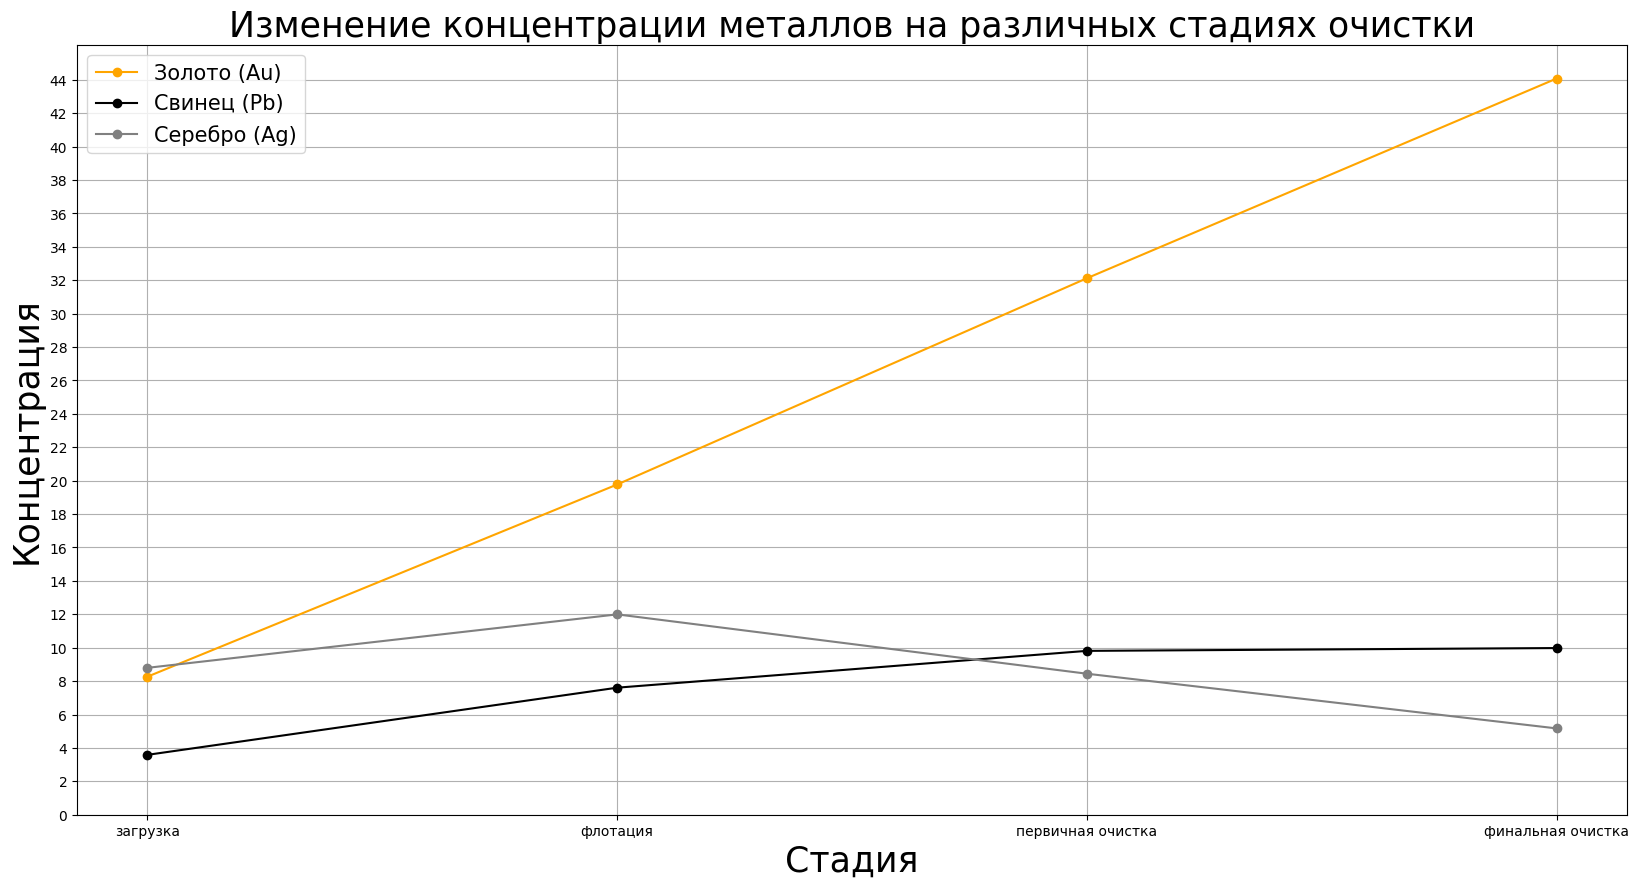

In [17]:
# строим график концентрации металлов на различных стадиях
plt.figure(figsize=(20, 10))
# выводим данные
plt.plot(gold_full_au.mean(), marker ='o', label='Золото (Au)', color='orange')
plt.plot(gold_full_pb.mean(), marker ='o', label='Свинец (Pb)', color='black')
plt.plot(gold_full_ag.mean(), marker ='o', label='Серебро (Ag)', color='gray')
# задаем параметры таблицы
plt.title('Изменение концентрации металлов на различных стадиях очистки', fontsize=25)
plt.xlabel('Стадия', fontsize=25)
plt.ylabel('Концентрация', fontsize=25)
plt.grid()
plt.legend(fontsize=15)
plt.yticks(np.arange(0, 45, 2))
plt.show()

Концентрация золота равномерно растет от первой стадии до последний.
Концентрации серебра в начале увеличиваться, а концу становится меньше чем в начале.
Концентрация свинца в начале увеличиваться и такой сохраняется до конца.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

C:\Users\Константин\AppData\Local\Temp\ipykernel_4640\4199150046.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=gold_test['rougher.input.feed_size'], color='red',
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

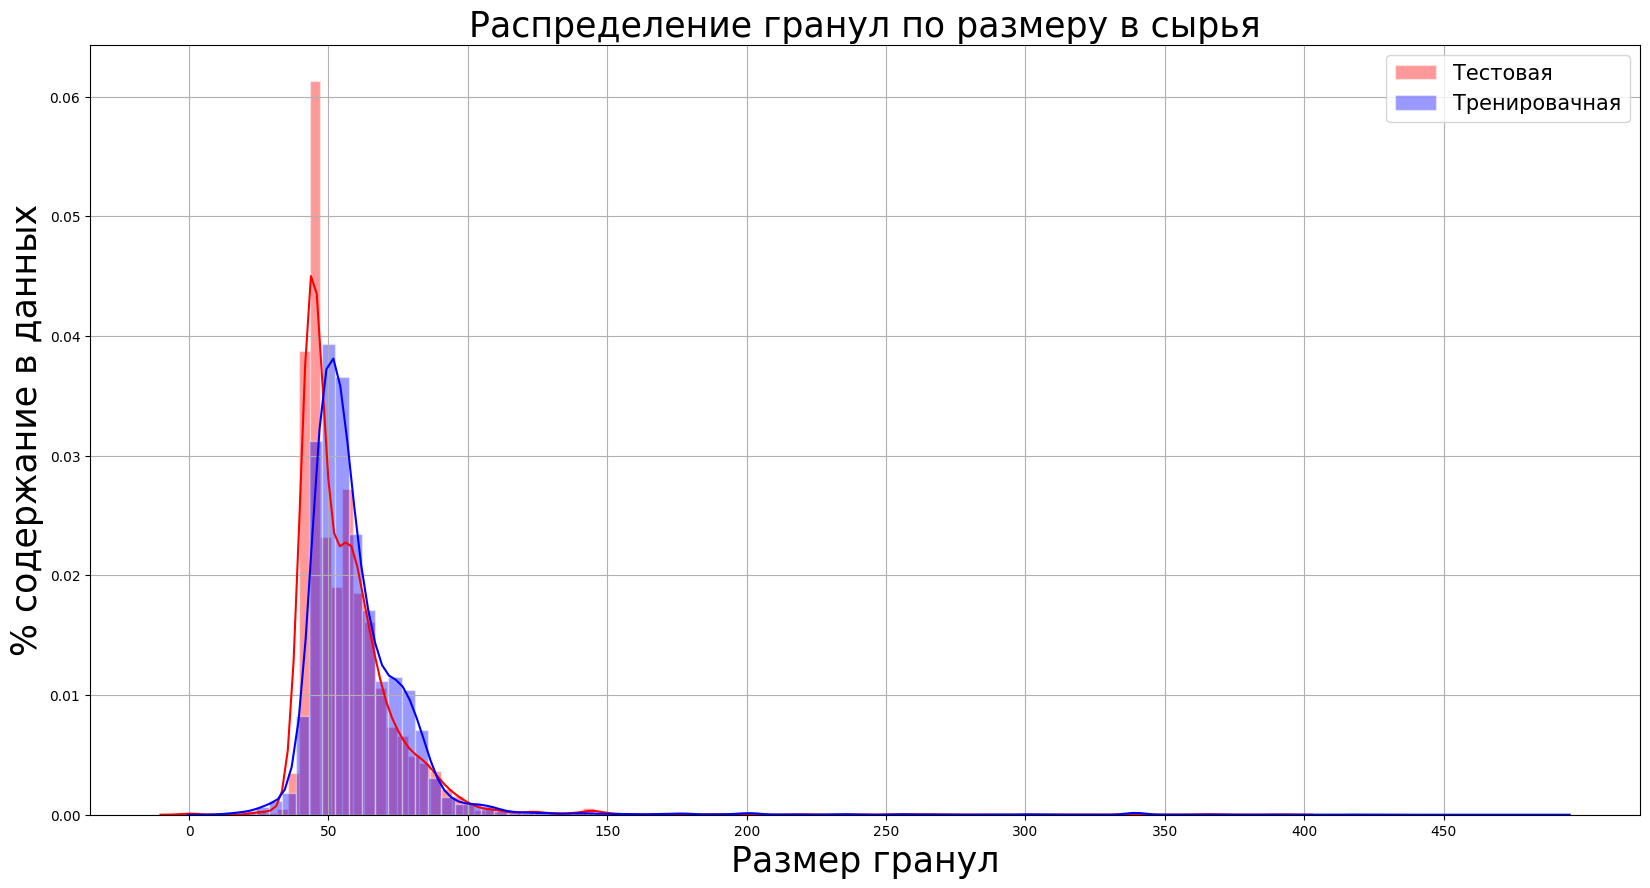

In [23]:
# строим график распределения частиц 
plt.figure(figsize=(20, 10))
# выводим данные
sns.distplot(a=gold_test['rougher.input.feed_size'], color='red',
             hist_kws={"edgecolor": 'white'}, label='Тестовая', bins = 100)

sns.distplot(a=gold_train['rougher.input.feed_size'], color='blue',
             hist_kws={"edgecolor": 'white'}, label='Тренировачная', bins = 100)
# задаем параметры таблицы
plt.title('Распределение гранул по размеру в сырья',fontsize=25)
plt.xlabel('Размер гранул',fontsize=25)
plt.ylabel('% содержание в данных',fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.xticks(np.arange(0, 500, 50))
plt.show()

In [24]:
# отрежем хвост, чтобы подробней разглядеть распределение
gold_test_chart = gold_test[(gold_test['rougher.input.feed_size'] < 100) 
                            & (gold_test['rougher.input.feed_size'] > 20)]

gold_train_chart = gold_train[(gold_train['rougher.input.feed_size'] < 100) 
                              & (gold_train['rougher.input.feed_size'] > 20)]

C:\Users\Константин\AppData\Local\Temp\ipykernel_4640\1423203129.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gold_test_chart['rougher.input.feed_size'], color='red',
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a futu

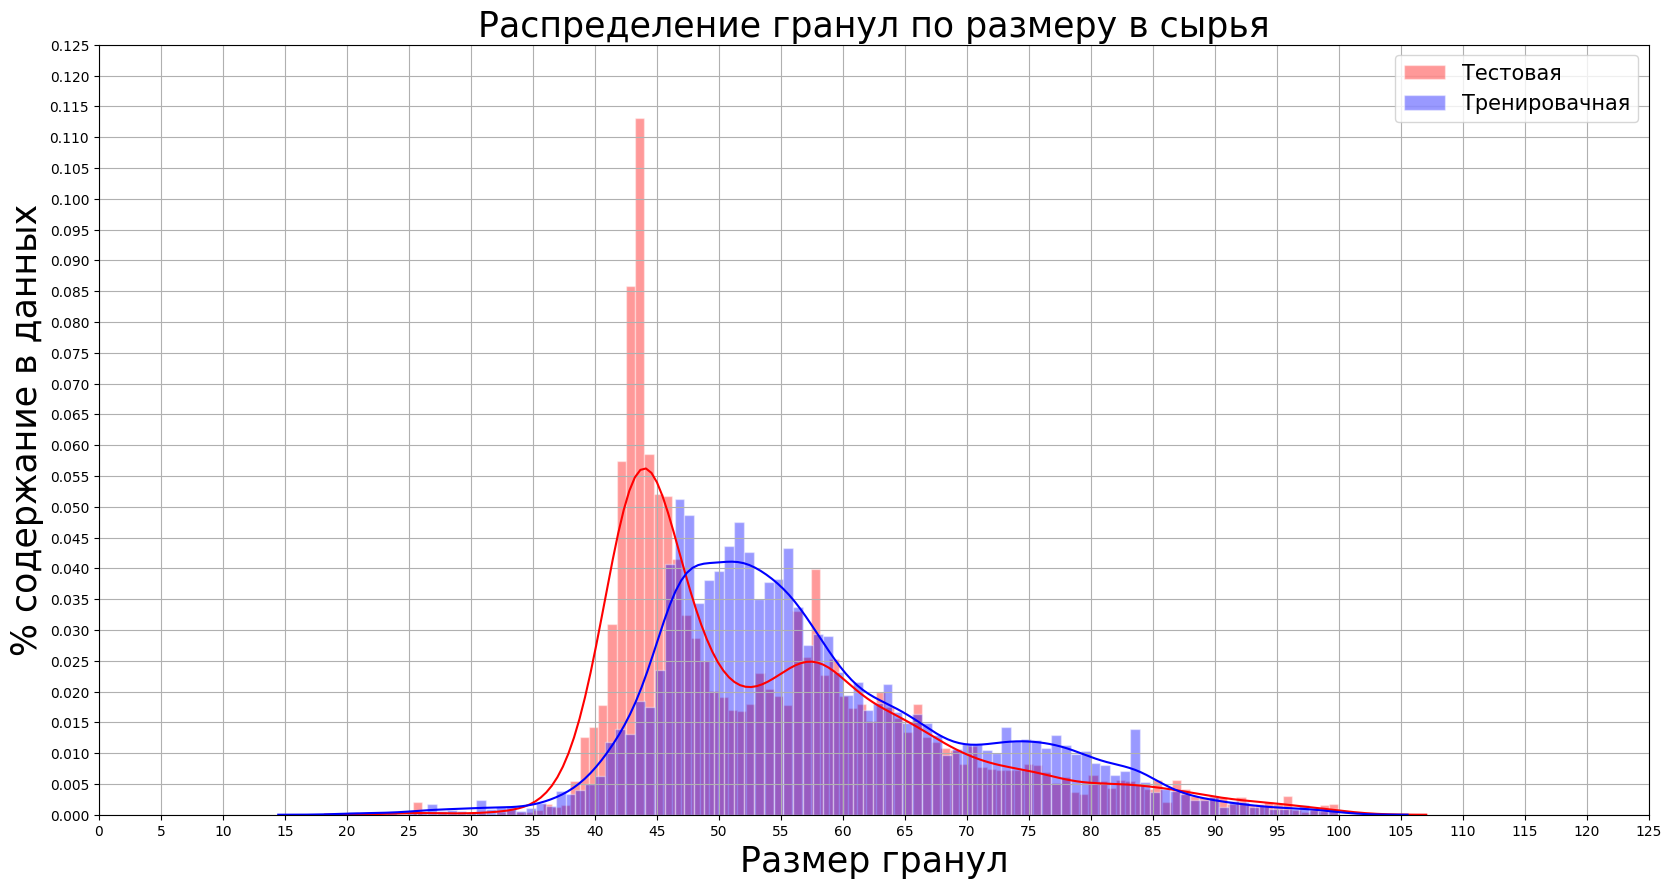

In [25]:
# строим график распределения частиц 
plt.figure(figsize=(20, 10))
# выводим данные
sns.distplot(gold_test_chart['rougher.input.feed_size'], color='red',
             hist_kws={"edgecolor": 'white'}, label='Тестовая', bins = 100)

sns.distplot(gold_train_chart['rougher.input.feed_size'], color='blue',
             hist_kws={"edgecolor": 'white'}, label='Тренировачная', bins = 100)
# задаем параметры таблицы
plt.title('Распределение гранул по размеру в сырья',fontsize=25)
plt.xlabel('Размер гранул',fontsize=25)
plt.ylabel('% содержание в данных',fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.xticks(np.arange(0, 130, 5))
plt.yticks(np.arange(0, 0.13, 0.005))
plt.show()

In [26]:
# сравним распределения частиц в выборках
alpha = .05 
sample_1 = gold_test['rougher.input.feed_size']
sample_2 = gold_train['rougher.input.feed_size']
results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = False)

if results.pvalue < alpha:
    print(results.pvalue)
    print('Есть вероятность, что выборки отличаются.')
else:
    print(results.pvalue)
    print('Есть вероятность, что выборки одинаковые.')

8.76128160307778e-37
Есть вероятность, что выборки отличаются.


In [27]:
# посмотрим на распределение подробней
display(gold_test['rougher.input.feed_size'].describe())
gold_train['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952835
std        19.080372
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

count    14149.000000
mean        60.097903
std         23.023690
min          9.659576
25%         48.950593
50%         55.269784
75%         65.982466
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Тест показал, что вероятнее всего выборки отличаются. На графики видно, что гистограмма тестовой выборки отличается от тренировочной и имеет два пика. Эти два пика как раз приходятся на один у тренировочной выборки, также различие в средних составляет не более 10%. С большой натяжкой примем эти выборки за схожие и применим для работы с моделями.

Исследуем суммарную концентрацию всех веществ на разных стадиях.

C:\Users\Константин\AppData\Local\Temp\ipykernel_4640\44756399.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gold_full[['rougher.input.feed_pb',
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf

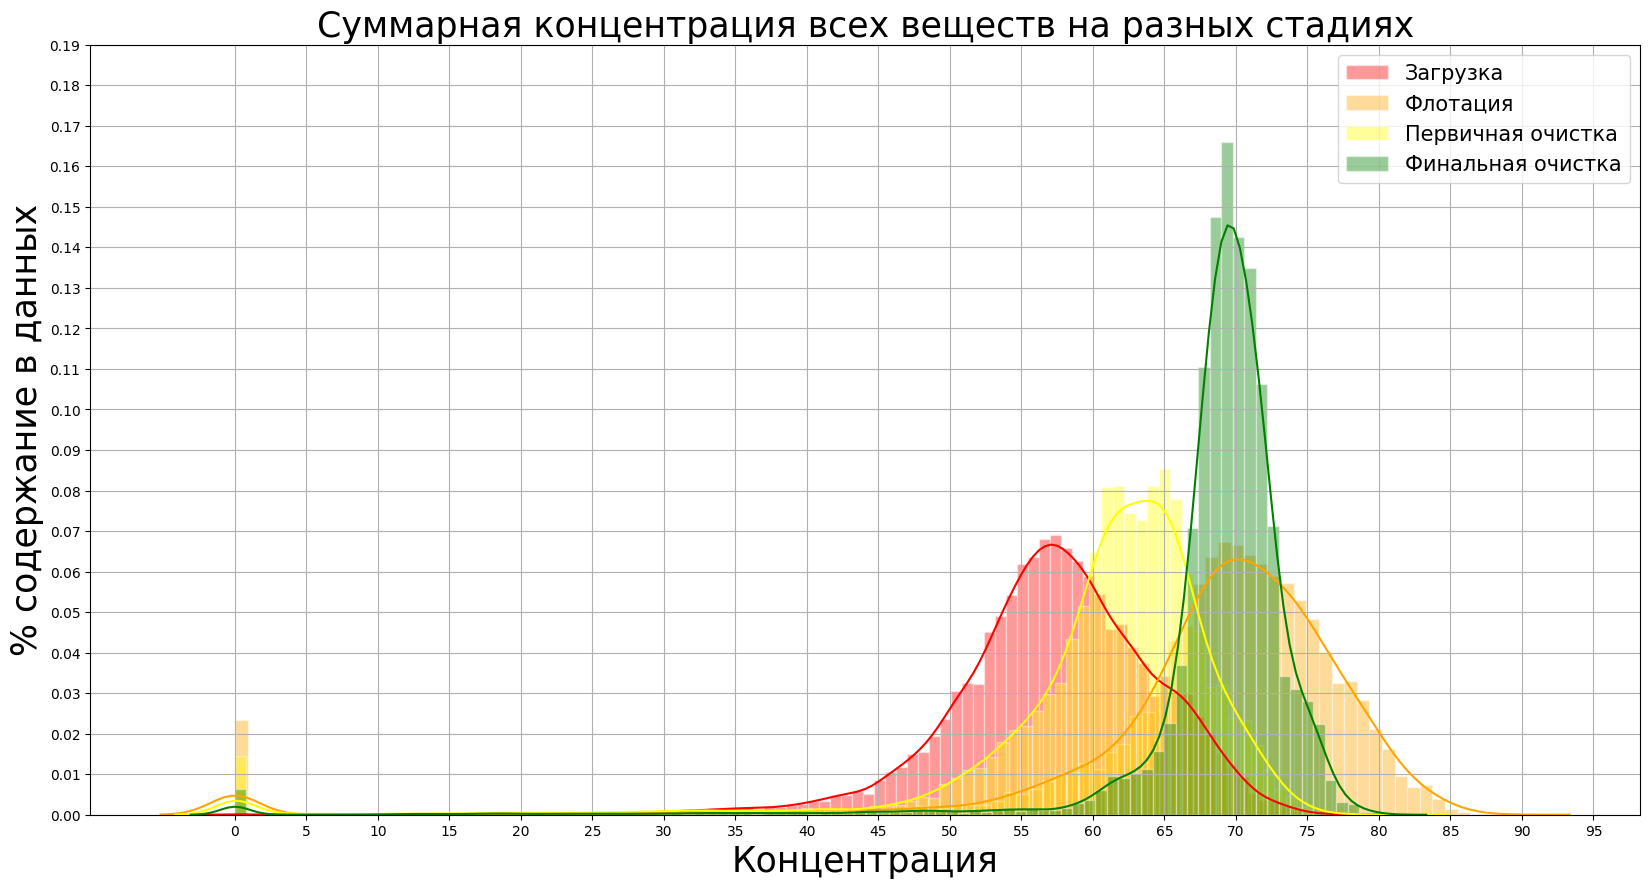

In [28]:
# строим график концентрации всех веществ на различных стадиях 
plt.figure(figsize=(20, 10))
# выводим данные
sns.distplot(gold_full[['rougher.input.feed_pb', 
                   'rougher.input.feed_sol',    
                   'rougher.input.feed_ag',  
                   'rougher.input.feed_au']].sum(axis=1), color='red',
             hist_kws={"edgecolor": 'white'}, label='Загрузка', bins = 100)

sns.distplot(gold_full[['rougher.output.concentrate_pb',
                        'rougher.output.concentrate_sol',
                   'rougher.output.concentrate_ag',  
                   'rougher.output.concentrate_au']].sum(axis=1), color='orange',
             hist_kws={"edgecolor": 'white'}, label='Флотация', bins = 100)

sns.distplot(gold_full[['primary_cleaner.output.concentrate_pb',
                        'primary_cleaner.output.concentrate_sol',
                   'primary_cleaner.output.concentrate_ag',  
                   'primary_cleaner.output.concentrate_au']].sum(axis=1), color='yellow',
             hist_kws={"edgecolor": 'white'}, label='Первичная очистка', bins = 100)

sns.distplot(gold_full[['final.output.concentrate_pb', 
                        'final.output.concentrate_sol',
                   'final.output.concentrate_ag',  
                   'final.output.concentrate_au']].sum(axis=1), color='green',
             hist_kws={"edgecolor": 'white'}, label='Финальная очистка', bins = 100)
# задаем параметры таблицы
plt.title('Суммарная концентрация всех веществ на разных стадиях',fontsize=25)
plt.xlabel('Концентрация',fontsize=25)
plt.ylabel('% содержание в данных',fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 0.20, 0.01))
plt.show()

Концентрация веществ сначала увеличивается затем уменьшается и к финалу резко возрастает это может быть связана с технологически процессом и разбавление смеси различными компонентами. Также в данных присутствуют аномалии с нулевым значением они могли возникнуть из-за сбоя оборудования. Удалим их.

In [29]:
# создадим список веществ
list_of_metals = ['rougher.input.feed_pb', 
'rougher.input.feed_ag',  
'rougher.input.feed_au',
'rougher.input.feed_sol',
'rougher.output.concentrate_pb', 
'rougher.output.concentrate_ag',  
'rougher.output.concentrate_au', 
'rougher.output.concentrate_sol',
'primary_cleaner.output.concentrate_pb', 
'primary_cleaner.output.concentrate_ag',  
'primary_cleaner.output.concentrate_au',
'primary_cleaner.output.concentrate_sol',
'final.output.concentrate_pb', 
'final.output.concentrate_ag',  
'final.output.concentrate_au',
'final.output.concentrate_sol']

In [30]:
print(gold_full.shape)
print(gold_train.shape)
gold_test.shape

(19439, 87)
(14149, 87)


(5290, 53)

In [31]:
# удалим аномалии
for lom in list_of_metals:
    gold_train = gold_train[gold_train[lom] > 1] 
for lom in list_of_metals:
    gold_full = gold_full[gold_full[lom] > 1]     

In [32]:
# создадим список веществ для тестовой выборки
list_of_metals_2 = [
'rougher.input.feed_pb', 
'rougher.input.feed_ag',  
'rougher.input.feed_au']

In [33]:
# удалим аномалии
for lom_2 in list_of_metals_2:
    gold_test = gold_test[gold_test[lom_2] > 1] 

In [34]:
print(gold_full.shape)
print(gold_train.shape)
gold_test.shape

(18435, 87)
(13344, 87)


(5276, 53)

## Модель

Подготовим данные для обучения модели. Добавим целевые признаки в тестовою выборку.
Удалим столбцы из тренировочной выборки которых нет в тестовых и в обоих удал время, чтобы не нагружать модель лишними данными.

In [35]:
#создадим датасет для целевых признаков, недостающих в тестовой выборке
gold_full_target = gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']]
gold_full_target.head()

,date,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,87.107763,70.541216
1,2016-01-15 01:00:00,86.843261,69.266198
2,2016-01-15 02:00:00,86.842308,68.116445
3,2016-01-15 03:00:00,87.226430,68.347543
4,2016-01-15 04:00:00,86.688794,66.927016


In [36]:
# добавим признаки в тестовую выборку из полной
gold_test = gold_test.merge(gold_full_target, how = 'left', on = 'date')

In [37]:
# удалим столбец с датой
gold_test.drop(['date'], axis=1, inplace=True)

In [38]:
#удалим из тренировочной выборки те признаки, которых нет в тестовой
gold_train = gold_train.drop(set(gold_train.columns)-set(gold_test.columns), axis=1)

In [39]:
display(gold_train.head())
display(gold_test.head())
print(gold_train.shape)
gold_test.shape

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,70.541216,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,87.107763,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,69.266198,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,86.843261,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,68.116445,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,86.842308,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,68.347543,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,1600.449520,-500.052575,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,87.226430,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.74672

(13344, 54)


(5276, 54)

Напишем функцию для вычисления итоговой sMAPE. Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она одинаково учитывает масштаб и целевого признака, и предсказания.

In [40]:
# функция для расчета sMAPE
def s_mape (target,predicted):
    return np.mean(abs(target - predicted)/((abs(target)+abs(predicted))/2))*100

In [41]:
# функция для расчета финального sMAPE
def s_mape_final(rougher,final):
    return (0.25*rougher + 0.75*final)

In [42]:
# функция разделения данных на признаки и целевой признак
def division (gold_data):
    #выделим признаки для чернового концентрата (rougher) 
    # оставим процессы относящиеся к черновому этапу
    features = gold_data.filter(regex='^rougher',axis=1)
    
    features_r = features.drop('rougher.output.recovery', axis=1)
    target_r = gold_data['rougher.output.recovery']

    #выделим признаки для финального концентрата (final)
    features_f = gold_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
    target_f = gold_data['final.output.recovery']
    
    return features_r, target_r, features_f, target_f

In [43]:
features_r_train, target_r_train, features_f_train, target_f_train = division(gold_train)
features_r_test, target_r_test, features_f_test, target_f_test = division(gold_test)

Масштабируещая количественные признаки.

In [44]:
# функция масштабируещая количественные признаки для линейной регрессии
def scale (train,test):
    numeric = train.columns
    scaler = StandardScaler()
    scaler.fit(train[numeric])

    train[numeric] = scaler.transform(train[numeric])
    test[numeric] = scaler.transform(test[numeric])
    return train, test

In [45]:
# создаем копию выборок с масштабированием для линейной регрессии
features_r_train_lr, features_r_test_lr = scale(features_r_train.copy(deep=True),features_r_test.copy(deep=True))
features_f_train_lr, features_f_test_lr = scale(features_f_train.copy(deep=True),features_f_test.copy(deep=True))

In [46]:
# проверим разделение 
print(features_r_train.shape)
print(target_r_train.shape)
print(features_f_train.shape)
print(target_f_train.shape)
print()
print(features_r_test.shape)
print(target_r_test.shape)
print(features_f_test.shape)
print(target_f_test.shape)


display(features_r_train.describe())
display(features_r_test.describe())
display(features_f_train.describe())
display(features_f_test.describe())

# проверим применение масштабирования для линейной регрессии
display(features_r_train_lr.describe())
display(features_r_test_lr.describe())
display(features_f_train_lr.describe())
features_f_test_lr.describe()

(13344, 22)
(13344,)
(13344, 52)
(13344,)

(5276, 22)
(5276,)
(5276, 52)
(5276,)


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000
mean,8.601794,3.541966,475.189964,59.981634,36.360975,7.930510,11.786112,5.891637,11.426458,5.813912,1123.465486,-370.589674,1322.766242,-463.760487,1302.431703,-464.607445,1212.581140,-465.019407,1088.994708,-464.418600,1036.365912,-464.202554
std,1.874551,1.045441,101.660162,22.708184,4.793783,1.834992,3.165551,1.079578,3.659193,1.300130,168.861960,94.242090,182.293033,57.441063,212.485957,55.879062,208.902881,55.733624,185.637121,56.527664,175.471038,56.601016
min,2.215688,1.006168,0.012786,9.659576,3.135927,1.513062,0.001164,0.001428,0.000098,0.000290,-0.041078,-650.086255,-0.653384,-558.967560,-0.035112,-610.357519,-0.124766,-640.519003,-1.936877,-648.002444,-2.430587,-649.880981
25%,7.141995,2.796450,424.920260,48.966094,34.073861,6.639926,9.944597,5.198854,9.619380,5.177339,999.789749,-499.802672,1199.404004,-500.177614,1103.131467,-500.207966,1060.108815,-500.349240,953.865370,-500.241441,901.164814,-500.463182
50%,8.179866,3.429822,499.463686,55.250331,36.995786,7.684622,11.772436,5.996719,11.474379,5.997705,1001.595888,-300.182672,1301.593156,-499.756721,1300.470703,-499.673423,1200.878574,-499.450394,1050.354984,-499.593762,1000.050595,-499.345975
75%,9.944426,4.235672,546.099739,65.719365,39.446876,9.102622,13.621305,6.686238,13.499098,6.699143,1299.469991,-299.964455,1449.883557,-400.391514,1450.592078,-400.613208,1346.778403,-400.973847,1200.085741,-400.554393,1100.168050,-400.929766
max,14.596026,7.142594,717.508837,484.967466,48.363177,13.126043,36.118275,9.703448,37.980648,9.698407,1521.980372,-281.039299,1809.194008,-296.383080,2499.129174,-292.155509,1817.199290,-282.986203,1922.636637,-272.199598,1706.307502,-191.718480


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000
mean,9.381433,3.806164,490.003900,55.941184,37.719517,9.347004,13.860506,6.470389,13.913907,6.500555,1053.581710,-395.735812,1318.794459,-475.263881,1301.398025,-474.896650,1214.764453,-475.706625,1056.499826,-469.033287,997.902561,-470.522538
std,1.915817,0.943043,107.557255,19.072659,5.450970,1.600938,3.349143,1.060121,3.248701,0.904508,121.220633,91.165141,156.202756,45.567985,171.106925,45.839773,185.572349,47.789235,131.341173,59.296709,128.056977,60.779120
min,2.667444,1.011167,0.147400,0.046369,1.393488,2.764981,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.065369,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-638.512817,-2.593390,-649.949283
25%,8.120768,3.243958,407.170113,43.903913,34.492280,8.218028,11.995321,5.998813,11.997074,5.998935,999.212147,-499.921369,1200.866132,-500.256678,1199.646076,-500.233969,1094.125023,-500.440348,999.357560,-500.191305,901.031223,-500.624363
50%,9.766896,3.744139,499.079325,50.854025,37.962506,9.595856,14.003231,6.498262,14.004430,6.498453,1000.474638,-399.695516,1302.254995,-499.838160,1300.202274,-499.778357,1207.014092,-499.692054,1047.495449,-499.767064,999.442816,-499.682728
75%,10.654592,4.286442,575.333338,62.401069,41.631002,10.465989,16.978372,7.090030,16.963962,7.090003,1006.300422,-300.059507,1431.415283,-450.785821,1406.405982,-451.266377,1391.379062,-452.824612,1101.343185,-451.072216,1050.421271,-452.753799
max,14.406130,6.905684,707.364020,392.494040,53.477742,13.731330,24.280636,8.910468,24.280966,8.621338,1423.274687,-273.776101,1706.640419,-298.200051,1731.017788,-298.036852,1775.218584,-76.397327,1467.184843,-139.753025,1476.588107,-249.801043


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,1.334400e+04,13344.000000,1.334400e+04,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000,13344.000000
mean,134.994872,8.915889,7.334718,0.882118,1606.760278,-488.413210,1607.351818,-489.016686,1607.900274,-489.154360,1539.840964,-483.370179,8.601794,3.541966,475.189964,59.981634,36.360975,7.930510,11.786112,5.891637,11.426458,5.813912,1123.465486,-370.589674,1322.766242,-463.760487,1302.431703,-464.607445,1212.581140,-465.019407,1088.994708,-464.418600,1036.365912,-464.202554,29.693181,-501.846460,24.920382,-503.264417,2.922378e+01,-477.539859,2.266601e+01,-488.370522,19.952425,-478.007752,15.487947,-459.939699,16.759032,-483.419279,13.034013,-483.425843,19.626837,-506.779055
std,38.053963,3.342711,0.610438,0.376342,128.953905,35.168442,131.651114,33.818364,134.832512,34.569548,280.407023,46.208428,1.874551,1.045441,101.660162,22.708184,4.793783,1.834992,3.165551,1.079578,3.659193,1.300130,168.861960,94.242090,182.293033,57.441063,212.485957,55.879062,208.902881,55.733624,185.637121,56.527664,175.471038,56.601016,5.799554,60.421712,6.002747,63.126142,5.636778e+00,54.994400,5.028465e+00,42.355374,5.635325,51.059430,5.275173,58.593424,5.827997,38.438561,5.754704,39.367835,5.735918,37.122831
min,0.051279,0.000000,1.080000,0.000005,0.016993,-633.597180,0.023275,-740.122129,0.040552,-782.912082,0.023153,-799.788598,2.215688,1.006168,0.012786,9.659576,3.135927,1.513062,0.001164,0.001428,0.000098,0.000290,-0.041078,-650.086255,-0.653384,-558.967560,-0.035112,-610.357519,-0.124766,-640.519003,-1.936877,-648.002444,-2.430587,-649

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5276.000000,5276.000000,5276.000000,5276.000000,5.276000e+03,5276.000000,5.276000e+03,5276.000000,5.276000e+03,5276.000000,5.276000e+03,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5.276000e+03,5276.000000,5.276000e+03,5276.000000,5.276000e+03,5276.000000,5.276000e+03,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000
mean,174.950324,8.690897,7.265587,1.384594,1.539606e+03,-497.590657,1.545289e+03,-500.063881,1.527356e+03,-498.271360,1.544987e+03,-500.151545,9.381433,3.806164,490.003900,55.941184,37.719517,9.347004,13.860506,6.470389,13.913907,6.500555,1053.581710,-395.735812,1318.794459,-475.263881,1301.398025,-474.896650,1214.764453,-475.706625,1056.499826,-469.033287,997.902561,-470.522538,26.316683,-502.714118,21.950879,-501.936995,2.537740e+01,-507.472075,2.098134e+01,-506.576556,1.632044e+01,-505.064787,1.373774e+01,-463.200098,12.803877,-501.277052,9.879391,-495.595229,17.307097,-501.740777
std,42.940681,3.074071,0.610004,0.643771,1.158908e+02,19.542603,1.213579e+02,32.152360,1.217335e+02,21.596995,1.236827e+02,30.808848,1.915817,0.943043,107.557255,19.072659,5.450970,1.600938,3.349143,1.060121,3.248701,0.904508,121.220633,91.165141,156.202756,45.567985,171.106925,45.839773,185.572349,47.789235,131.341173,59.296709,128.056977,60.779120,3.429329,28.630653,4.357512,34.402330,6.550526e+00,47.504656,6.737930e+00,44.453900,3.481668e+00,31.158303,3.426314e+00,85.853625,3.025220,17.512959,2.866423,34.325230,4.533269,38.880293
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-783.448551,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,2.667444,1.011167,0.147400,0.046369,1.393488,2.764981,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.065369,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-638.512817,-2.593390,-649.949

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04
mean,6.304576e-16,3.407879e-17,3.407879e-17,-2.215121e-16,6.815758e-17,-3.919061e-16,-3.663470e-16,8.860485e-16,4.472841e-16,7.497333e-16,1.312033e-15,-1.703939e-16,1.738018e-15,6.815758e-17,1.465388e-15,-8.519697e-16,7.156546e-16,2.726303e-16,-3.407879e-16,4.430242e-16,5.452606e-16,3.407879e-16
std,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00
min,-3.406866e+00,-2.425669e+00,-4.674348e+00,-2.216115e+00,-6.931121e+00,-3.497393e+00,-3.723014e+00,-5.456233e+00,-3.122762e+00,-4.471738e+00,-6.653652e+00,-2.965841e+00,-7.260120e+00,-1.657536e+00,-6.129890e+00,-2.608411e+00,-5.805336e+00,-3.149018e+00,-5.876909e+00,-3.247803e+00,-5.920267e+00,-3.280602e+00
25%,-7.787750e-01,-7.131387e-01,-4.945063e-01,-4.851094e-01,-4.771178e-01,-7.033447e-01,-5.817576e-01,-6.417402e-01,-4.938644e-01,-4.896411e-01,-7.324348e-01,-1.371127e+00,-6.767503e-01,-6.340149e-01,-9.379806e-01,-6.371233e-01,-7.298992e-01,-6.339289e-01,-7.279492e-01,-6.337460e-01,-7.705327e-01,-6.406596e-01
50%,-2.250905e-01,-1.072743e-01,2.387821e-01,-2.083601e-01,1.324287e-01,-1.340046e-01,-4.320407e-03,9.733939e-02,1.309660e-02,1.413706e-01,-7.217384e-01,7.471146e-01,-1.161530e-01,-6.266873e-01,-9.229191e-03,-6.275569e-01,-5.602127e-02,-6.178008e-01,-2.081543e-01,-6.222879e-01,-2.069668e-01,-6.209206e-01
75%,7.162686e-01,6.635779e-01,6.975440e-01,2.526819e-01,6.437539e-01,6.387799e-01,5.797607e-01,7.360566e-01,5.664413e-01,6.809047e-01,1.042337e+00,7.494302e-01,6.973502e-01,1.103241e+00,6.972975e-01,1.145270e+00,6.424147e-01,1.149180e+00,5.984536e-01,1.129829e+00,3.636186e-01,1.117916e+00
max,3.197809e+00,3.444253e+00,2.383706e+00,1.871580e+01,2.503795e+00,2.831471e+00,7.686837e+00,3.530966e+00,7.257116e+00,2.987887e+00,2.360092e+00,9.502520e-01,2.668484e+00,2.914007e+00,5.632101e+00,3.086279e+00,2.894363e+00,3.266251e+00,4.490875e+00,3.400569e+00,3.818104e+00,4.814300e+00


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000
mean,0.415922,0.252724,0.145726,-0.177936,0.283407,0.771964,0.655327,0.536111,0.679806,0.528154,-0.413867,-0.266835,-0.021789,-0.200272,-0.004865,-0.184140,0.010452,-0.191762,-0.175052,-0.081639,-0.219209,-0.111663
std,1.022052,0.902087,1.058048,0.839934,1.137134,0.872482,1.058036,0.982014,0.887852,0.695732,0.717895,0.967387,0.856909,0.793330,0.805292,0.820370,0.888352,0.857490,0.707542,1.049025,0.729817,1.073857
min,-3.165863,-2.420887,-4.673024,-2.639467,-7.294613,-2.815120,-3.723019,-5.457029,-3.122768,-4.466589,-6.653658,-3.049284,-7.260495,-3.243531,-6.129992,-3.273925,-5.809488,-3.290260,-5.877154,-3.079921,-5.921195,-3.281808
25%,-0.256618,-0.285066,-0.669116,-0.708041,-0.389831,0.156692,0.066092,0.099279,0.155946,0.142317,-0.735855,-1.372386,-0.668729,-0.635391,-0.483747,-0.637589,-0.567060,-0.635564,-0.482880,-0.632859,-0.771294,-0.643507
50%,0.621560,0.193392,0.235001,-0.401967,0.334097,0.907584,0.700416,0.561930,0.704546,0.526538,-0.728379,-0.308853,-0.112522,-0.628105,-0.010493,-0.629435,-0.026650,-0.622137,-0.223559,-0.625354,-0.210431,-0.626870
75%,1.095129,0.712144,0.985117,0.106549,1.099387,1.381790,1.640300,1.110099,1.513370,0.981548,-0.693877,0.748422,0.596035,0.225886,0.489341,0.238758,0.855922,0.218813,0.066522,0.236112,0.080104,0.202279
max,3.096503,3.217632,2.283911,14.643393,3.570751,3.161342,3.947178,2.796411,3.513067,2.159424,1.775536,1.027324,2.105887,2.882374,2.017085,2.981024,2.693398,6.973109,2.037331,5.743696,2.508897,3.788087


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04,1.334400e+04
mean,-4.174652e-16,-2.129924e-16,1.772097e-15,1.703939e-16,-1.789136e-16,2.146964e-15,-1.363152e-16,1.959530e-16,1.218317e-15,1.789136e-16,3.620871e-16,-1.184238e-15,6.304576e-16,3.407879e-17,3.407879e-17,-2.215121e-16,6.815758e-17,-3.919061e-16,-3.663470e-16,8.860485e-16,4.472841e-16,7.497333e-16,1.312033e-15,-1.703939e-16,1.738018e-15,6.815758e-17,1.465388e-15,-8.519697e-16,7.156546e-16,2.726303e-16,-3.407879e-16,4.430242e-16,5.452606e-16,3.407879e-16,-1.703939e-16,-1.448349e-16,-6.645364e-16,-8.093712e-16,6.900955e-16,-5.793394e-16,5.623000e-16,3.919061e-16,4.771030e-16,2.112885e-15,-1.533545e-16,5.111818e-16,1.533545e-16,1.567624e-15,3.407879e-17,2.044727e-16,-1.022364e-16,-9.201273e-16
std,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00
min,-3.546244e+00,-2.667363e+00,-1.024667e+01,-2.344000e+00,-1.2

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000
mean,1.050008,-0.067311,-0.113253,1.335209,-0.520780,-0.260967,-0.471436,-0.326675,-0.597389,-0.263739,0.018354,-0.363180,0.415922,0.252724,0.145726,-0.177936,0.283407,0.771964,0.655327,0.536111,0.679806,0.528154,-0.413867,-0.266835,-0.021789,-0.200272,-0.004865,-0.184140,0.010452,-0.191762,-0.175052,-0.081639,-0.219209,-0.111663,-0.582221,-0.014361,-0.494709,0.021029,-0.682399,-0.544298,-0.335039,-0.429856,-0.644527,-0.529932,-0.331795,-0.055647,-0.678673,-0.464597,-0.548202,-0.309132,-0.404439,0.135724
std,1.128458,0.919669,0.999327,1.710664,0.898733,0.555707,0.921849,0.950772,0.902883,0.624764,0.441099,0.666762,1.022052,0.902087,1.058048,0.839934,1.137134,0.872482,1.058036,0.982014,0.887852,0.695732,0.717895,0.967387,0.856909,0.793330,0.805292,0.820370,0.888352,0.857490,0.707542,1.049025,0.729817,1.073857,0.591331,0.473865,0.725947,0.544998,1.162148,0.863841,1.340008,1.049585,0.617852,0.610259,0.649541,1.465298,0.519103,0.455626,0.498120,0.871943,0.790360,1.047381
min,-3.480155,-2.666214,-2.759957,-2.330769,-12.460425,-8.389521,-12.209635,-9.195950,-11.925614,-8.991088,-5.491655,-6.848013,-3.165863,-2.420887,-4.673024,-2.639467,-7.294613,-2.815120,-3.723019,-5.457029,-3.122768,-4.466589,-6.653658,-3.049284,-7.260495,-3.243531,-6.129992,-3.273925,-5.809488,-3.290260,-5.877154,-3.079921,-5.921195,-3.281808,-5.084694,-4.671420,-4.150642,-4.665747,-5.184678,-5.859288,-4.507709,-7.578130,-3.540731,-6.302515,-2.936117,-5.818230,-2.863836,-8.166707,-2.173248,-8.047340,-3.4357

Обучим и проверим несколько моделей.

In [47]:
# таблица для сбора sMAPE моделей
table_1 = pd.DataFrame({'Модель': [], 'sMAPE': []})

In [48]:
# определим метрику расчитываемую при кросс-валидации
scorer = make_scorer(s_mape, greater_is_better=False)

Решающее дерево

In [49]:
%%time
# создадим модель
model=DecisionTreeRegressor(random_state=RANDOM_STATE)
# зададим гиперпараметры для обучение
parameters={'max_depth' : range (1, 5, 1)}

tuning_model=GridSearchCV(model,param_grid=parameters,scoring=scorer) # рассчитаем sMAPE при кросс-валидации
tuning_model.fit(features_r_train, target_r_train)
tuning_model1=GridSearchCV(model,param_grid=parameters,scoring=scorer) # рассчитаем sMAPE при кросс-валидации
tuning_model1.fit(features_f_train, target_f_train)

# добавим данные в таблицу 
dtr = 'Решающее дерево'
table_1.loc[ len(table_1.index )] = [dtr, s_mape_final(tuning_model.best_score_,
                                                            tuning_model1.best_score_).mean()]

# рассчитаем финальное sMAPE и выведем лучшие параметры модели
print('Итоговое sMAPE для решающего дерева:',s_mape_final(tuning_model.best_score_,
                                                            tuning_model1.best_score_).mean(),
      '\nПараметры', tuning_model.best_params_, tuning_model1.best_params_) 

Итоговое sMAPE для решающего дерева: -8.519968588456404 
Параметры {'max_depth': 4} {'max_depth': 2}
CPU times: total: 8.14 s
Wall time: 8.13 s


Линейная регрессия

In [50]:
%%time
model2=LinearRegression()

parameters={}
tuning_model2=GridSearchCV(model2,param_grid=parameters, scoring=scorer)
tuning_model2.fit(features_r_train_lr, target_r_train)
tuning_model22=GridSearchCV(model2,param_grid=parameters, scoring=scorer)
tuning_model22.fit(features_f_train_lr, target_f_train)

lr = 'Линейная регрессия'
table_1.loc[ len(table_1.index )] = [lr, s_mape_final(tuning_model2.best_score_,
                                                            tuning_model22.best_score_).mean()]

print('Итоговое sMAPE для линейной регрессии:',s_mape_final(tuning_model2.best_score_,
                                                            tuning_model22.best_score_).mean(),
      '\nПараметры',tuning_model2.best_params_, tuning_model22.best_params_)

Итоговое sMAPE для линейной регрессии: -9.60970393466471 
Параметры {} {}
CPU times: total: 203 ms
Wall time: 232 ms


Случайный лес

In [51]:
%%time
model3=RandomForestRegressor(random_state=RANDOM_STATE)

parameters={'n_estimators': range (1, 101, 10),
            'max_depth' : range (1, 11, 3),
            'max_features':['sqrt']
           }

tuning_model3=GridSearchCV(model3,param_grid=parameters, scoring=scorer)
tuning_model3.fit(features_r_train, target_r_train)
tuning_model33=GridSearchCV(model3,param_grid=parameters, scoring=scorer)
tuning_model33.fit(features_r_train, target_r_train)

rfr = 'Случайный лес'
table_1.loc[ len(table_1.index )] = [rfr, s_mape_final(tuning_model3.best_score_,
                                                            tuning_model33.best_score_).mean()]

print('Итоговое sMAPE для случайного леса:',s_mape_final(tuning_model3.best_score_,
                                                            tuning_model33.best_score_).mean(),
      '\nПараметры', tuning_model3.best_params_, tuning_model33.best_params_)

Итоговое sMAPE для случайного леса: -6.319142619310266 
Параметры {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 91} {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 91}
CPU times: total: 11min 18s
Wall time: 11min 17s


In [52]:
table_1.sort_values('sMAPE',ascending=False)

,Модель,sMAPE
2,Случайный лес,-6.319143
0,Решающее дерево,-8.519969
1,Линейная регрессия,-9.609704


Точнее всего предсказала результаты модель Случайный лес с sMAPE -8.806470 и параметрами:  
'max_depth': 4, 'n_estimators': 9

Точнее всего предсказала результаты модель Случайный лес с sMAPE -6.319105 и параметрами:  
Параметры {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 91} {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 91}

Проверим данную модель на тестовой выборке и сравним с проверочной.

Тест лучшей модели

In [53]:
# рассчитаем финальное sMAPE для тестовой выборки на лучшей модели
model_r = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=91 ,max_depth = 4, max_features = 'sqrt')
model_f = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=91 ,max_depth = 4, max_features = 'sqrt')

model_r.fit(features_r_train, target_r_train)
model_f.fit(features_f_train, target_f_train)

test_predictions_r = model_r.predict(features_r_test)
test_predictions_f = model_f.predict(features_f_test)

bm = 'Тест лучшей модели'
table_1.loc[ len(table_1.index )] = [bm, s_mape_final(s_mape(target_r_test,test_predictions_r)
                     ,s_mape(target_f_test,test_predictions_f))]

print('Итоговое sMAPE для тестовой выборки:', s_mape_final(s_mape(target_r_test,test_predictions_r)
                     ,s_mape(target_f_test,test_predictions_f)))

Итоговое sMAPE для тестовой выборки: 6.6729320100252


Cтандартная проверочная модель

In [54]:
# рассчитаем финальное sMAPE для тестовой выборки на проверочной модели
dummy_model_r = DummyRegressor(strategy='mean')
dummy_model_f = DummyRegressor(strategy='mean')
dummy_model_r.fit(features_r_train, target_r_train)
dummy_model_f.fit(features_f_train, target_f_train)
dummy_test_predictions_r = dummy_model_r.predict(features_r_test)
dummy_test_predictions_f = dummy_model_f.predict(features_f_test)

dm = 'Cтандартная проверочная модель'
table_1.loc[ len(table_1.index )] = [dm, 
                                     s_mape_final(s_mape(target_r_test,dummy_test_predictions_r), 
                                                         s_mape(target_f_test,dummy_test_predictions_f))]


print('Итоговое sMAPE для DummyRegressor:', 
      s_mape_final(s_mape(target_r_test,dummy_test_predictions_r), 
                                                         s_mape(target_f_test,dummy_test_predictions_f)))

Итоговое sMAPE для DummyRegressor: 7.6151081599017125


In [55]:
# для наглядности уберем отрицательное значение
table_1['sMAPE'] = table_1['sMAPE'].abs()
table_1.sort_values('sMAPE',ascending=True)

,Модель,sMAPE
2,Случайный лес,6.319143
3,Тест лучшей модели,6.672932
4,Cтандартная проверочная модель,7.615108
0,Решающее дерево,8.519969
1,Линейная регрессия,9.609704


Тест модели Случайный лес показал лучший результат чем среднее на проверочной. Модель адекватна и может делать расчеты для подготовки процесса очистки золота.

**Вывод**  
Подготовка данных.  
Устранены пропуски.
Показатель эффективности обогащения был пересчитан и является корректным.  
Из тестовой выборки были удалены данные которые не влияют на итоги целевых признаков.  
Анализ данных.  
Изучена концентрации металлов. Золото растет в разы больше остальных.  
Изучено распределение гранул сырья для обучающей и тестовой выборок. Есть отличее. 
Изучена суммарная концентрация всех веществ на разных стадиях: в сырье, после флотации, первого этапа очистки и в финальном концентрате.  
Модель.
Внесены целевые признаки в тестовою модель.
Подготовлены признаки для обучения на трех алгоритмах. 
Проведены замеры sMAPE на крос-валидации данных моделей.
Случайный лес показала лучше результаты и был принят за основную модель.  
Тест модели Случайный лес показал лучший результат чем среднее на проверочной. Модель адекватна и может делать расчеты для подготовки процесса очистки золота.  